In [12]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2
import dask.dataframe as dd
import dask.array as da
import itertools

In [3]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)
logger.addHandler(logging.FileHandler('Logs/pairsim_{0}.log'.format(datetime.datetime.now().\
                                                            strftime("%Y-%m-%d"), 'a')))
print = logging.info
print('good day to you madam fiona')
print('started')
print(datetime.datetime.now())

INFO:root:good day to you madam fiona
INFO:root:started
INFO:root:2018-07-22 22:50:15.893641


## 1. Similarity

See helpful code here: https://stackoverflow.com/questions/3992735/python-generator-that-groups-another-iterable-into-groups-of-n

In [13]:
def grouper(n, iterable):
    """
    >>> list(grouper(3, 'ABCDEFG'))
    [['A', 'B', 'C'], ['D', 'E', 'F'], ['G']]
    """
    iterable = iter(iterable)
    return iter(lambda: list(itertools.islice(iterable, n)), [])

seq = [1,2,3,4,5,6,7]
print(list(grouper(3, seq)))

INFO:root:[[1, 2, 3], [4, 5, 6], [7]]


In [24]:
n_rows = 3000
n_chunks = int(np.round(len(l3)/n_rows))
cos_dis = np.empty((n_chunks,n_rows))

In [31]:
c = np.empty(20)
c[3:50]

array([6.2400e-321, 6.2400e-321, 6.2400e-321, 6.2400e-321, 6.2400e-321,
       6.2400e-321, 6.2400e-321, 2.2584e-320, 2.2584e-320, 2.2584e-320,
       2.2584e-320, 2.2584e-320, 2.2584e-320, 2.2584e-320, 2.2584e-320,
       2.2584e-320, 2.2584e-320])

In [32]:
np.shape(cos_dis)

(663, 3000)

In [36]:
import scipy.spatial.distance as distance
dms = ["ldavecs", "docvecs"]
files = ["uni_pats_samp_0722"]
try:
    res = {}
    for dm in dms:
        print("Loading matrix and dict")
        print(datetime.datetime.now())
        
        pat_dict = fastparquet.ParquetFile("RawData/Cleaned/patabs7615_us_no_dup.parq").to_pandas(["patent"])["patent"].tolist()
        pat_dict = dict(zip(pat_dict, range(len(pat_dict))))
        # Store as dask array
        if dm == "ldavecs":
            ncols = 60
        else:
            ncols = 100
        pm = dd.read_parquet("DataStore/2018-07-P2/ML/{0}_pats_0712.parq".format(dm)).values.compute()
        pm = da.from_array(pm, chunks=(10000,ncols))

        print("Getting row values")
        print(datetime.datetime.now())

        for f in files:
            print("Loading sample data")
            print(f)
            # 1. Load data
            l2 = pd.read_pickle("DataStore/2018-07-P2/UniPats/{0}.pkl".format(f))
            
            #----------#
            # 2. Get pat vecs & pat similarity
            print(len(l2))
            # Remove missing values
            l3 = l2.loc[l2["tp"].isin(pat_dict.keys()) & l2["op"].isin(pat_dict.keys())]
            
            if dm == "ldavecs":
                ncols = 60
            else:
                ncols = 100
            print(len(l3))

            print("Getting chunks")
            print(datetime.datetime.now())
            # Split into chunks
            n_rows = 3000
            n_chunks = int(np.round(len(l3)/n_rows))
            tp_chunks = grouper(n_rows, pm[[pat_dict[p] for p in l3["tp"].tolist()]].compute())
            op_chunks = grouper(n_rows, pm[[pat_dict[p] for p in l3["op"].tolist()]].compute())
            chunks = itertools.zip_longest(tp_chunks, op_chunks)
            
            print("Getting patent pair similarity")
            print("cosine")
            print(datetime.datetime.now())
            # Cosine
            
            cos_dis = np.empty(len(l3))
            
            for r, c in enumerate(chunks):
                cos_dis[r*n_rows:r*n_rows+n_rows] = np.diag(distance.cdist(c[0],c[1], metric = "cosine"))
     
            l3["sim_{0}".format(dm)] = 1-cos_dis
            del(cos_dis)
            
            pair_sim = l2.merge(l3[["tp", "op", "sim_{0}".format(dm)]], how = "left", on = ["tp", "op"])
            res[dm] = pair_sim
            print(len(pair_sim))           
            print("Finished this file")
            print(datetime.datetime.now())
            
        # Exit inner loop
        del(pm,pat_dict)
            #----------#
except Exception as e:
    logging.exception("message")

INFO:root:Loading matrix and dict
INFO:root:2018-07-22 23:51:35.366656
INFO:root:Getting row values
INFO:root:2018-07-22 23:51:45.021136
INFO:root:Loading sample data
INFO:root:uni_pats_samp_0722
INFO:root:1994578
INFO:root:1988493
INFO:root:Getting chunks
INFO:root:2018-07-22 23:51:46.137409
INFO:root:Getting patent pair similarity
INFO:root:cosine
INFO:root:2018-07-22 23:51:51.258421
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
INFO:root:1996102
INFO:root:Finished this file
INFO:root:2018-07-22 23:54:50.703051
INFO:root:Loading matrix and dict
INFO:root:2018-07-22 23:54:50.800624
INFO:root:Getting row values
INFO:root:2018-07-22 23:55:08.905896
INFO:root:Loading sa

In [37]:
ts = res["ldavecs"].merge(res["docvecs"], how = "left", on = ["tp", "op"])
ts.to_pickle("DataStore/2018-07-P2/UniPats/uni_pats_samp_0722.pkl")
print(ts["tp"].min())
del(res)

INFO:root:3930273


In [38]:
pdf = fastparquet.ParquetFile("RawData/Cleaned/patent_loc_unique_us_0628.parq").to_pandas(\
                                    ["patent", "appyear", "gyear", "naics_name", "primclass", "inv_msa"]).drop_duplicates("patent")
uni_pats = pd.read_pickle("DataStore/2018-07-P2/UniPats/uni_pats_0722.pkl")["patent"]
ts = pd.read_pickle("DataStore/2018-07-P2/UniPats/uni_pats_samp_0722.pkl")    
ts = ts.merge(pdf.add_prefix("tp_"), how = "left", left_on="tp", right_on="tp_patent").drop("tp_patent",1)
print(len(ts))
ts = ts.merge(pdf.add_prefix("op_"), how = "left", left_on="op", right_on="op_patent").drop("op_patent",1)
print(len(ts))
del(pdf)
# Add year diff
ts["year_diff"] = ts["op_appyear"] - ts["tp_appyear"]
# Add if software
ts["tp_is_uni"] = ts["op_is_uni"] = False
ts.loc[ts["tp"].isin(uni_pats.tolist()), "tp_is_uni"] = True
ts.loc[ts["op"].isin(uni_pats.tolist()), "op_is_uni"] = True

for c in ["naics_name", "primclass", "inv_msa"]:
    ts["{0}_match".format(c)] = (ts["tp_{0}".format(c)] == ts["op_{0}".format(c)])

eps = 0.01
dv_min = 0.7
def scale_docvecs(x):
    scaled = ((x+dv_min)/(1+dv_min))*(1-eps)+eps
    return scaled
def scale_ldavecs(x):
    scaled = x*(1-eps)+eps
    return scaled
ts["sim_ldavecs"] = ts["sim_ldavecs"].apply(scale_ldavecs)
ts["sim_docvecs"] = ts["sim_docvecs"].apply(scale_docvecs)

ts.to_pickle("DataStore/2018-07-P2/UniPats/uni_pats_samp_transformed_0722.pkl")



INFO:root:2005254
INFO:root:2005254


____

## 2. Software patent similarity
### 2.1 Similarity as software patent enters Computers industry

In [55]:
ts = pd.read_pickle("DataStore/2018-07-P2/UniPats/uni_pats_samp_transformed_0722.pkl")
yr_min = 1975
yr_max = 1990
ts = ts.loc[ts["tp_appyear"].isin(range(yr_min,yr_max+1))]

In [56]:
# Average by target patent similarity
k = "tp_is_uni"
yr_col = "tp"
tg = ts.groupby([yr_col]).mean().reset_index()
tp_all_lda = tg[["sim_ldavecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
tp_all_dv = tg[["sim_docvecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
tp_sw_lda_tp = tg.loc[(tg[k]==True), ["sim_ldavecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
tp_sw_dv_tp = tg.loc[(tg[k]==True), ["sim_docvecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()

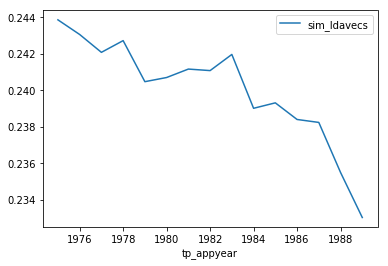

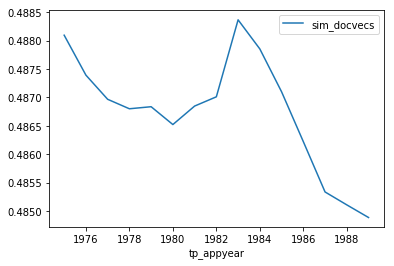

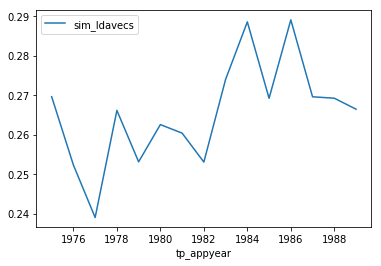

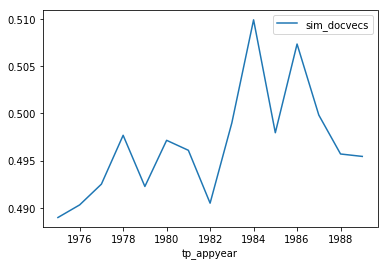

In [57]:
%matplotlib inline
tp_all_lda.plot.line()
tp_all_dv.plot.line()
tp_sw_lda_tp.plot.line()
tp_sw_dv_tp.plot.line()

In [58]:
# Don't average similarity by tp
all_lda = ts[["sim_ldavecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
all_dv = ts[["sim_docvecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
sw_lda_tp = ts.loc[(ts[k]==True), ["sim_ldavecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
sw_dv_tp = ts.loc[(ts[k]==True), ["sim_docvecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
sw_lda_op = ts.loc[(ts["op_is_uni"]==True), ["sim_ldavecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
sw_dv_op = ts.loc[(ts["op_is_uni"]==True), ["sim_docvecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
nsw_lda_op = ts.loc[(ts[k]==False) & (ts["op_is_uni"]==True), ["sim_ldavecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()
nsw_dv_op = ts.loc[(ts[k]==False) & (ts["op_is_uni"]==True), ["sim_docvecs", "{0}_appyear".format(yr_col)]].groupby("{0}_appyear".format(yr_col)).mean()

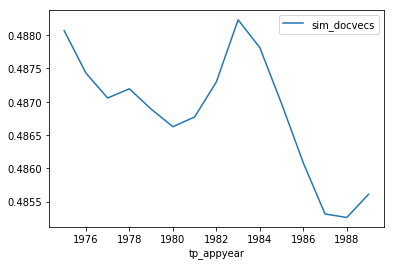

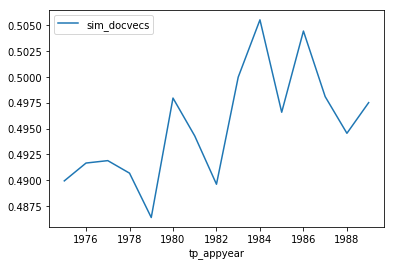

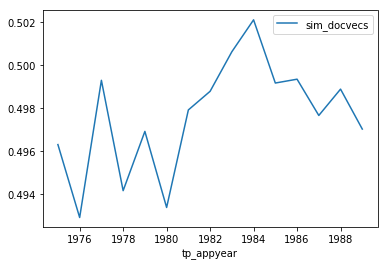

In [59]:
%matplotlib inline
# all_lda.plot.line()
all_dv.plot.line()
# sw_lda_tp.plot.line()
sw_dv_tp.plot.line()
# sw_lda_op.plot.line()
sw_dv_op.plot.line()
# nsw_lda_op.plot.line()
# nsw_dv_op.plot.line()

### 2.2 Localization with university patents

In [60]:
len(ts)

2005254

In [61]:
print("op_is_uni")
k = "op_is_uni"
sw_lda_mt = ts.loc[(ts[k]==True) & (ts["inv_msa_match"] == True),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").mean()
sw_lda_mf = ts.loc[(ts[k]==True) & (ts["inv_msa_match"] == False),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").mean()
sw_lda_m = sw_lda_mt-sw_lda_mf
sw_dv_mt = ts.loc[(ts[k]==True) & (ts["inv_msa_match"] == True),
                   ["sim_docvecs", "tp_appyear"]].groupby("tp_appyear").mean()
sw_dv_mf = ts.loc[(ts[k]==True) & (ts["inv_msa_match"] == False),
                   ["sim_docvecs", "tp_appyear"]].groupby("tp_appyear").mean()
sw_dv_m = sw_dv_mt-sw_dv_mf
print("tp_is_uni")
k = "tp_is_uni"
sw_lda_mt_tp = ts.loc[(ts[k]==True) & (ts["inv_msa_match"] == True),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").mean()
sw_lda_mf_tp = ts.loc[(ts[k]==True) & (ts["inv_msa_match"] == False),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").mean()
sw_lda_m_tp = sw_lda_mt-sw_lda_mf
sw_dv_mt_tp = ts.loc[(ts[k]==True) & (ts["inv_msa_match"] == True),
                   ["sim_docvecs", "tp_appyear"]].groupby("tp_appyear").mean()
sw_dv_mf_tp = ts.loc[(ts[k]==True) & (ts["inv_msa_match"] == False),
                   ["sim_docvecs", "tp_appyear"]].groupby("tp_appyear").mean()
sw_dv_m_tp = sw_dv_mt-sw_dv_mf

lda_mt = ts.loc[ (ts["inv_msa_match"] == True),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").mean()
lda_mf = ts.loc[(ts["inv_msa_match"] == False),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").mean()
lda_m = lda_mt-lda_mf
dv_mt = ts.loc[(ts["inv_msa_match"] == True),
                   ["sim_docvecs", "tp_appyear"]].groupby("tp_appyear").mean()
dv_mf = ts.loc[(ts["inv_msa_match"] == False),
                   ["sim_docvecs", "tp_appyear"]].groupby("tp_appyear").mean()
dv_m = dv_mt-dv_mf

INFO:root:op_is_uni
INFO:root:tp_is_uni


INFO:root:op_is_uni
INFO:root:tp_is_uni
INFO:root:all spillovers


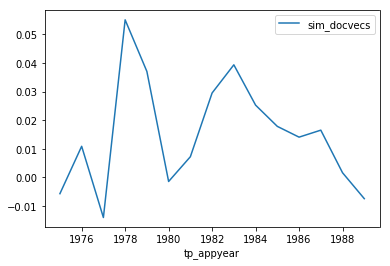

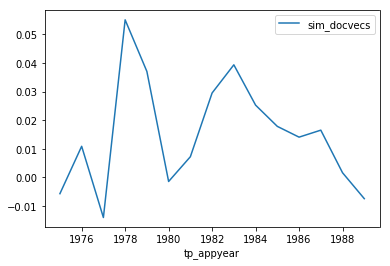

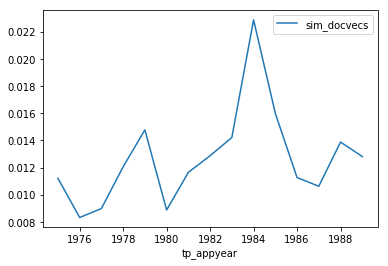

In [62]:
%matplotlib inline
print("op_is_uni")
# sw_lda_m.plot.line()
sw_dv_m.plot.line()
print("tp_is_uni")
# sw_lda_m_tp.plot.line()
sw_dv_m_tp.plot.line()

print("all spillovers")
# lda_m.plot.line()
dv_m.plot.line()

In [63]:
sw_lda_mt_s = ts.loc[(ts["tp_is_uni"]==True) & (ts["inv_msa_match"] == True),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").size()
sw_lda_mf_s = ts.loc[(ts["tp_is_uni"]==True) & (ts["inv_msa_match"] == False),
                   ["sim_ldavecs", "tp_appyear"]].groupby("tp_appyear").size()

In [64]:
sw_lda_mt_s

tp_appyear
1975.0    20
1976.0    17
1977.0    12
1978.0    10
1979.0     1
1980.0    49
1981.0    37
1982.0    22
1983.0    18
1984.0    10
1985.0    85
1986.0    90
1987.0    69
1988.0    33
1989.0    25
dtype: int64

In [65]:
sw_lda_mf_s

tp_appyear
1975.0     917
1976.0    1008
1977.0     732
1978.0     404
1979.0     218
1980.0    1908
1981.0    1510
1982.0    1319
1983.0     844
1984.0     499
1985.0    2847
1986.0    2767
1987.0    2743
1988.0    2021
1989.0    1073
dtype: int64

In [66]:
len(ts)

2005254